<p>
<img src="https://drive.google.com/uc?id=1ZHUKcwzA5c-PKUwoGmBG3TsHk6TmZ-Y0" align="left" width="250">
</p>
<p>
<h1><b><center>Mecánica de Medios Continuos</center></b></h1>
<h2><b><center>Prof. Jorge I. Zuluaga</center></b></h1>
<h2><b><center>Tarea 2</center></b><h2>
<h3><b><center>Atmósfera Empírica</center></b><h3>
<h5><center><b>Asignada</b>: 6 de Marzo de 2024</center><h5>
<h5><center><b>Entrega</b>: 19 de Marzo de 2024</center><h5>
</p>

<hr/>
<b>Nombre</b>: Bryan Camilo Restrepo Arcila
<br/>
<b>Cédula</b>: 1000567825
<br/>
<b>Última actualización</b>: 19-03-2024
<hr/>

## Enunciado

**Objetivo**: El objetivo de esta tarea es comparar los distintos modelos de atmósferas vistos en el curso, frente al modelo de atmósfera empírica [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) (_US Naval Research Laboratory mass spectrometer and incoherent scatter radar_). Este modelo puede darnos información de la atmósfera en distintas ubicaciones en la Tierra, épocas del año, horas del día e incluso épocas del ciclo solar.

**Procedimiento**:

Para conseguir el objetivo:

1. Obtener los datos de la atmósfera desde la superficie hasta 100 km en una ubicación, fecha y hora específica cada 50 metros.  Para ello puede usar el día y lugar de nacimiento. Asuma para la hora de nacimiento las 12 m (medio día). Para la ubicación use la ciudad del mundo que siempre ha soñado visitar o que más ha disfrutado visitar.

2. Usando los datos de composición de la atmósfera, calcule la presión atmosférica a cada altura. Asuma para ello la ecuación de estado de gas ideal.  Haga gráficos de temperatura, densidad y presión con la altura, usando la convención en ciencias atmosféricas de poner la altura en el eje y.

3. Evalúe si en la atmósfera calculada hay equilibrio hidrostático, es decir, si se cumple a cada altura la condición:

  $$
\frac{dp}{dz} = -\rho(z) g(z)
$$
   Use valores de la aceleración de la gravedad que varíen con la altura.

3. Llamamos tropopausa a la altura en la atmósfera en la que la temperatura deja de disminuir con la altura. Encuentre la altura de la **tropopausa** para el sitio y lugar elegido. A la capa de la atmósfera debajo de esa altura se la llama la **troposfera**.

4. Haga un gráfico de contornos sobre un mapa (use el código de ejemplo mostrado al final del enunciado) en el que muestre la altura de la troposfera como función de la longitud y la latitud. Observe. Haga una animación mostrando la temperatura en la superficie de la Tierra a lo largo de 1 día.

5. Vamos a determinar los mejores parámetros de un modelo homentrópico que ajustan las curvas de presión, densidad y temperatura para la troposfera de la atmósfera real (en el sitio y fecha que eligio en 1). Nuestros parámetros libres serán: $h_0$, $\gamma$ y temperatura superficial $T_0$.  Asuma valores para estas tres cantidades como los que usamos en ejemplos en clase y calcule el valor del estadístico $\chi^2$:

 $$
 \chi^2(h_0, \gamma, T_0) = \sum_i\frac{[T_\text{hom}(z_i)-T(z_i)]^2}{T(z_i)^2} + \sum_i\frac{[\rho_\text{hom}(z_i)-\rho(z_i)]^2}{\rho(z_i)^2}+ \sum_i\frac{[p_\text{hom}(z_i)-p(z_i)]^2}{p(z_i)^2}
 $$
 donde $z_i$ son las distintas alturas en las que se calcula el valor del perfil de los campos, $T(z)$ es la temperatura del modelo empírico, $T_\text{hom}(z)$ es la temperatura calculada con el modelo homentrópico; lo mismo aplica para los otros campos.

 Ahora minimize el valor de $\chi^2$ con respecto a los parámetros $h_0, \gamma, T_0$ para encontrar el modelo homentrópico que mejor se adapta a los perfiles de temperatura, densidad y presión de la tropósfera. Una vez hecho el ajuste haga gráficos de los tres campos y evalúe visualmente la calidad del ajuste.

 **Ayuda**: Para la minimizaciún puede usar la rutina `scipy.optimize.minimize`.

6. Repita el procedimiento anterior para muchos puntos en la superficie de la Tierra y haga mapas de $h_0$, $\gamma$ y $T_0$ sobre la superficie del planeta. Comente los resultados que obtiene.

**Resultados esperados**:

- Este notebook con el procedimiento debidamente comentado.

- Gráficos mínimos:
  - Gráficos de cada punto.

- Datos mínimos:
  - Los números solicitados en cada punto.

- En caso de utilizar ayudas como `ChatGPT` o códigos de `Stack Over Flow` debe citar debidamente la fuente, pero también entender a cabalidad el código, el profesor puede pedir justificación.

## ¿Cómo hacer mapas con `cartopy`

El paquete `cartopy` es el _standard de facto_ para hacer mapas con `matplotlib`. Aquí encuentra la documentación: https://scitools.org.uk/cartopy/docs/v0.5/index.html.

## Solución

Instalación de las librerías necesarias

In [56]:
!pip install -Uq cartopy nrlmsise00 'nrlmsise00[dataset]' mendeleev celluloid 

Importación de las librerias 

In [57]:
# Bibliotecas estándar
from datetime import datetime, timedelta

# Bibliotecas de terceros
import cartopy.crs as ccrs
from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt
from mendeleev import element
import numpy as np
from scipy.optimize import minimize
import warnings

# Importaciones de paquetes locales
from nrlmsise00.dataset import msise_4d


Constantes

In [58]:
# Constantes generales
R = 8.31446261815324 # J/(mol K) Constante de los gases ideales
RT = 6371e3 # m Radio de la Tierra

# Conversion de unidades
gr2kg = 1e-3 # gr a kg
gr_cm3_2_kg_m3 = 1e3 # gr/cm^3 a kg/m^3
m2km = 1e-3 # m a km
atm=101.325e3 # Pa

# Propiedades de la atmósfera terrestre
go = 9.80665 # m/s^2
rho_o = 1.225 # kg/m^3
po = 1*atm # Pa

1. Obtener los datos de la atmósfera desde la superficie hasta 100 km en una ubicación, fecha y hora específica cada 50 metros.  Para ello puede usar el día y lugar de nacimiento. Asuma para la hora de nacimiento las 12 m (medio día). Para la ubicación use la ciudad del mundo que siempre ha soñado visitar o que más ha disfrutado visitar.

In [59]:
# Ignorar advertencias
warnings.simplefilter('ignore')

# Fecha de nacimiento a las 12:00 medio día
date = datetime(2002, 7, 26, 12, 0, 0)

# Altura máxima de la atmósfera a 100 km
h_max = 100e3 # m

# Alturas de 0 a h_max de 50 en 50 metros
zs = np.arange(0, h_max, 50) # m

# Coordenadas geográficas de Japon
lat = 35.68 # grados
lon = 139.76 # grados

# Obtenemos un objeto de nrmlmsise00 con los datos de la atmosfera en mi cumpleaños en Japon
ds = msise_4d(date, zs*m2km, [lat], [lon])

2. Usando los datos de composición de la atmósfera, calcule la presión atmosférica a cada altura. Asuma para ello la ecuación de estado de gas ideal.  Haga gráficos de temperatura, densidad y presión con la altura, usando la convención en ciencias atmosféricas de poner la altura en el eje y.

Para esto tengamos en cuenta que la ecuación de estado del gas ideal esta dada por:

$$
\frac{p}{\rho} = \frac{RT}{M_\text{mol}}
$$

A partir de los datos que nos provee el modelo nrmlmsise00, podemos obtener el Mmol promedio, veamos:

In [60]:
# Definamos los elementos con mayor presencia en la atmósfera junto con su respectivo Mmol
species = [
    dict(name='N2',Mmol=2*element('Nitrogen').atomic_weight), # N2
    dict(name='O2',Mmol=2*element('Oxygen').atomic_weight), # O2
    dict(name='Ar',Mmol=1*element('Argon').atomic_weight), # Ar
    dict(name='N',Mmol=1*element('Nitrogen').atomic_weight), # N
    dict(name='O',Mmol=1*element('Oxygen').atomic_weight), # O
    dict(name='H',Mmol=1*element('Hydrogen').atomic_weight), # H
]

# Arrays para guardar la densidad y la masa de cada especie
ns = np.zeros(len(species))
ms = np.zeros(len(species))

# Extrae el Mmol de numero de particulas de cada especie por cm^3
for i, specie in enumerate(species):
  # Número de particulas por cm^3 de la especie
  ns[i] = np.array(ds[specie['name']]).flatten()[-1]
  
  # Mmol proporcionado por la abundancia de la especie
  ms[i] = specie['Mmol']*ns[i]

# Número total de Atomos o moleculas
n = ns.sum()

# Masa molar promedio
Mmol = ms.sum()/n

# Llevandolo al sistema internacional
Mmol = Mmol*gr2kg # kg/mol

In [61]:
# Obtiene los datos de densidad y temperatura empíricos
rhos_emp = np.array(ds["rho"]).flatten() # gr/cm^3
Ts_emp = np.array(ds["Talt"]).flatten() # K

# Lleva la densidad al sistema internacional
rhos_emp = rhos_emp*gr_cm3_2_kg_m3 # kg/m^3

# Usan la ecuación del gas ideal para obtener la presión empírica
Ps_emp = rhos_emp * R * Ts_emp / Mmol # Pa

Graficando la densidad, presión y temperartura con la altura

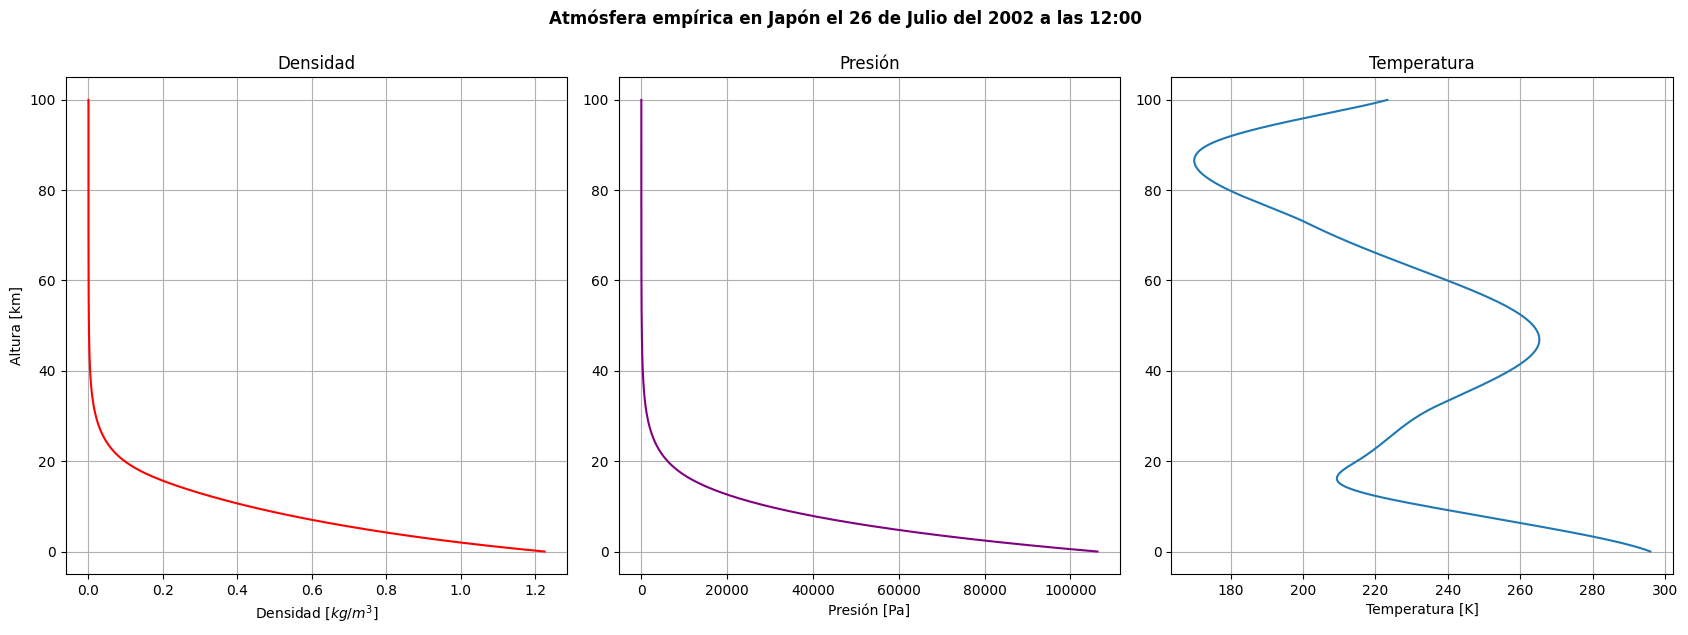

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

# Densidad
axs[0].plot(rhos_emp, zs*m2km, color='r')
axs[0].set_title('Densidad')
axs[0].set_xlabel(r'Densidad $[kg/m^3]$')
axs[0].set_ylabel('Altura [km]')
axs[0].grid(True)

# Presión
axs[1].plot(Ps_emp, zs*m2km, color='purple')
axs[1].set_title('Presión')
axs[1].set_xlabel('Presión [Pa]')
axs[1].grid(True)

# Temperatura
axs[2].plot(Ts_emp, zs*m2km)
axs[2].set_title('Temperatura')
axs[2].set_xlabel('Temperatura [K]')
axs[2].grid(True)

# Ajusta el espacio entre los subplots
plt.tight_layout()

# Agregando un titulo global al gráfico
plt.suptitle(f'Atmósfera empírica en Japón el 26 de Julio del 2002 a las 12:00',
              y=1.05, fontweight='bold')
plt.show()

3. Evalúe si en la atmósfera calculada hay equilibrio hidrostático, es decir, si se cumple a cada altura la condición:

  $$
\frac{dp}{dz} = -\rho(z) g(z)
$$
   Use valores de la aceleración de la gravedad que varíen con la altura.


Hagamos una función que pueda encontrar la gravedad con la altura:
La gravedad en un planeta en función del radio y la altura esta dada por:

$$
g(z) = \frac{G M}{(R+z)^2}
$$
Si tomamos como referencia la gravedad superficial:

$$
g(z) = g_0 \frac{R^2}{(R+z)^2} = \frac{g_0}{(1+z/R)^2}
$$

In [63]:
# Función para calcular la gravedad en función de la altura
g = lambda z:go/(1+z/RT)**2

Traduciendo esta propiedad:
  $$
  \frac{dp}{dz} = -\rho(z) g(z)
  $$
A un lenguaje que entienda python
$$
\frac{\Delta p}{\Delta z} = -\rho(z) g(z)
$$

Ahora comprobemos la igualdad, para esto verifiquemos que la diferencia entre un lado de la igualdad y el otro debe ser lo más pequeña posible

In [64]:
# Guardando los datos del cociente de la diferencia entre las presiones y la diferencia entre las alturas
lado_izquierdo = []
for i in range(1, len(Ps_emp)):
    lado_izquierdo.append((Ps_emp[i] - Ps_emp[i-1])/(zs[i] - zs[i-1]))

# Calculando el producto de la densidad por la gravedad en función de la altura
lado_derecho = - rhos_emp[1:]*g(zs[1:])

# Encuentra la diferencia entre los dos lados de la igualdad
Diferencia = lado_izquierdo - lado_derecho

Grafiquemos la diferencia

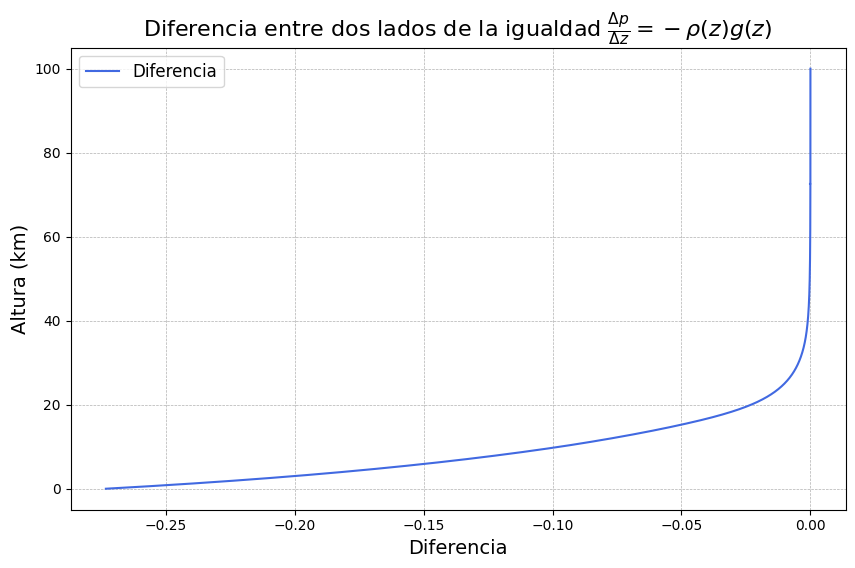

In [65]:

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Grafica la diferencia
ax.plot( Diferencia, zs[1:]*m2km, label='Diferencia', linestyle='-', marker='', color='royalblue')

# Añade títulos y etiquetas
ax.set_title(r'Diferencia entre dos lados de la igualdad $\frac{\Delta p}{\Delta z} = -\rho(z) g(z)$ ', fontsize=16)
ax.set_ylabel('Altura (km)', fontsize=14)
ax.set_xlabel('Diferencia', fontsize=14)

# Añade una leyenda
ax.legend(fontsize=12)

# Añade una cuadrícula para mejor lectura
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

Como se ve en el gráfico si bien al inicio la diferencia no es completamente 0 (aunque no esta muy lejos), con la altura esta si se vuelve 0, comprobando que efectivamente:
  $$
  \frac{dp}{dz} = -\rho(z) g(z)
  $$

3. Llamamos tropopausa a la altura en la atmósfera en la que la temperatura deja de disminuir con la altura. Encuentre la altura de la **tropopausa** para el sitio y lugar elegido. A la capa de la atmósfera debajo de esa altura se la llama la **troposfera**.

Según el gráfico del punto 2 para la temperatura podemos darnos de cuenta que la troposfera esta cerca a los 20 km kilometros de altura, pero calculemos númericamente la altura de la troposfera en Japon en mi cumpleaños, para esto solo es necesario verificar el array que contiene los datos de nuestra temperatura con la altura, y ir haciendo un analisis de si cada elemento es menor que el anterior, sin embargo, se va a encontrar que hay un punto en el array donde esto no se cumple y es justo cuando la temperatura empezara a aumentar y es precisamente este punto del array que marca la troposfera, después solo basta con encontrar su equivalente en el array de las alturas

In [66]:
# Iteramos sobre cada temperatura para verificar si es mayor que la anterior
for i in range(1, len(Ts_emp)):
    if Ts_emp[i] > Ts_emp[i-1]:
        # Si se cumple la condición, entonces aqui se ecnuentra la tropopausa
        h_troposfera = zs[i]*m2km  
        print(f'La tropopausa esta aproximadamente a {h_troposfera:.2f} km de altura.')
        break

La tropopausa esta aproximadamente a 16.20 km de altura.


4. Haga un gráfico de contornos sobre un mapa (use el código de ejemplo mostrado al final del enunciado) en el que muestre la altura de la troposfera como función de la longitud y la latitud. Observe. Haga una animación mostrando la temperatura en la superficie de la Tierra a lo largo de 1 día.

Primero dado del procedimiento para el punto anterior, hagamos una función que permita dada una latitud y una longitud encontrar la tropopausa

In [67]:
def tropopausa(latitud, longitud, date):
    """
    Función que calcula la altura de la tropopausa en base a la latitud,
    longitud y la fecha de estudio.

    Parameters:
        latitud : float latitud del lugar 
        longitud : float longitud del lugar

    Returns:
        h_troposfera : float altura de la tropopausa en km del lugar
    """
    # Ignoran los warnings ya que la libreria msise_4d esta desactualizada a los modelo actuales
    warnings.simplefilter('ignore')
    
    # Obtenemos un objeto de nrmlmsise00 con los datos de la atmosfera en mi cumpleaños en Japon
    ds = msise_4d(date, zs*m2km, [latitud], [longitud])

    # Obtiene los datos de la temperatura empíricos
    Ts_emp = np.array(ds["Talt"]).flatten() # K

    # Iteramos sobre cada temperatura para verificar si es mayor que la anterior
    for i in range(1, len(Ts_emp)):
        if Ts_emp[i] > Ts_emp[i-1]:
            h_troposfera = zs[i]*m2km  
            break

    return h_troposfera

Ahora encontremos la altura de la tropopausa para diferentes latitudes y longitudes

In [68]:
# Define los array de latitud y longitud y hacemos un mesgrid con ellos
lats = np.linspace(-90, 90, 15)
lons = np.linspace(-180, 180, 15)
LONS, LATS = np.meshgrid(lons,lats)

# Crea un array para guardar las alturas de la tropopausa
h_troposfera = np.zeros(LONS.shape)

# Itera sobre cada latitud y longitud para calcular la altura de la tropopausa correspondiente
for i in range(LONS.shape[0]):
    for j in range(LONS.shape[1]):    
        h_troposfera[i,j] = tropopausa(LATS[i,j], LONS[i,j], date)

Graficando la tropopausa en las diferentes regiones del planeta

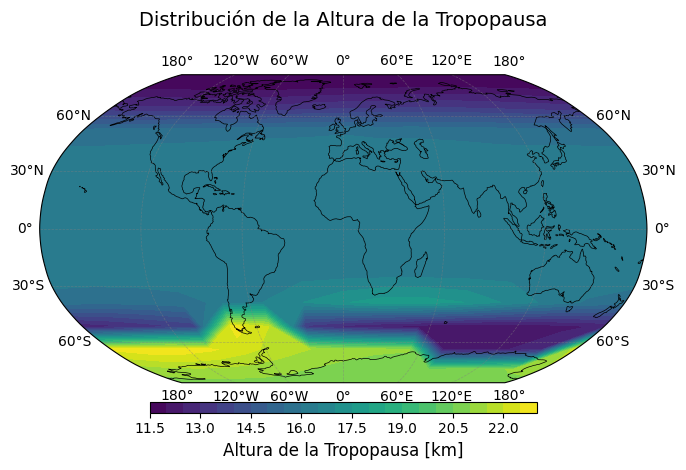

In [69]:
# Configuraciones inciales del gráfico	
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()

# Líneas costeras más finas
ax.coastlines(resolution='110m', linewidth=0.5)  
# Cuadrícula con etiquetas
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5,
              linestyle='--') 

# Grafica la altura de la tropopausa en función de la latitud y longitud
tropopause_contour = ax.contourf(LONS, LATS, h_troposfera, 24, transform=ccrs.PlateCarree(), cmap='viridis')

# Barra de color 
cbar = plt.colorbar(tropopause_contour, orientation='horizontal', pad=0.05, aspect=36, shrink=0.5)
cbar.set_label('Altura de la Tropopausa [km]', fontsize=12)  # Etiqueta de la barra de color
cbar.ax.tick_params(labelsize=10)  # Tamaño de la fuente para los ticks de la barra de color

# Título y mejoras en las etiquetas
plt.title('Distribución de la Altura de la Tropopausa', fontsize=14, pad=20)

# Muestra el gráfico
plt.show()

Ahora veamos la temperatura superficial dada una latitud, longitud y fecha

In [70]:
# Fecha de inicio de la animación
start_date = datetime(2002, 7, 26, 0, 0, 0)

# Paso de tiempo en minutos
delta_t = 30  # minutos
n = int(1440/delta_t)  # Número de pasos de tiempo en un día

# Lista que almacena cada punto de tiempo incrementado en delta_t
dates = [start_date + timedelta(minutes=delta_t)*i for i in range(n)]

# Hace un mesgrid de latitudes y longitudes
lats = np.linspace(-90, 90, 20)
lons = np.linspace(-180, 180, 20)
LONS, LATS = np.meshgrid(lons,lats)

# Obtiene los datos de la temperatura superficial para diferentes latitudes y longitudes
ds = msise_4d(dates, 0, lats, lons)

# Reestructura a un formato más simple
Ts_emp = np.array(ds["Talt"]).reshape(len(dates), len(lats), len(lons))

# Calcula el máximo y mínimo de la temperatura superficial para todos los tiempos, para la barra de color
Tmin = np.min(Ts_emp)
Tmax = np.max(Ts_emp)

In [71]:
# Configuraciones inciales para la animación
fig = plt.figure(figsize=(10, 5))

# Configuraciones inciales para el gráfico actual
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
camera = Camera(fig)
c_bar = None # Verifica si ya existe la barra de color

for i, Temp_date in enumerate(Ts_emp):  
    # Configuraciones iniciales del gráfico
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=0.5)  # Líneas costeras más finas
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Grafica la temperatura superficial
    temperature_contour = ax.contourf(LONS, LATS, Temp_date, 24, transform=ccrs.PlateCarree(),
                                      cmap='viridis', vmin=Tmin, vmax=Tmax)
    
    
    # Elimina el Axes de la barra de color anterior si existe
    if cbar:
        cbar.remove()

    # Agregar la barra de color
    cbar = fig.colorbar(temperature_contour, ax=ax, orientation='horizontal', pad=0.05, aspect=36, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Temperatura [K]')

    # Agrega un texto con la fecha
    date_text = dates[i].strftime('%H-%M')  # Formato de la fecha
    ax.text(0.05, 0.95, date_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            verticalalignment='top', horizontalalignment='left')

    camera.snap()  # Capturar el estado actual para la animación

# Crear la animación
animation = camera.animate(200)
plt.title('Variacion temperatura superficial en un dia')
plt.close()

# Mostrar animación en formato HTML
HTML(animation.to_html5_video())

# Guardar la animación en un archivo .gif
animation.save('Variacion_temperatura_superficial_en_un_dia.gif', fps=2)

Si no oberva la animación verifique el sistema de archivos que allí estara, también estará anexada en esta tarea, al igual para las siguientes animaciones

Ahora hagamos la misma animación pero para todo un año

In [72]:
# Fecha de inicio de la animación
start_date = datetime(2002, 7, 26, 0, 0, 0)

# Paso de tiempo en días
delta_t = 10  # días
n = int(365/delta_t)  # Número de pasos de tiempo en 1 año

# Lista que almacena cada punto de tiempo incrementado en delta_t
dates = [start_date + timedelta(days=delta_t)*i for i in range(n)]

# Haciendo un mesgrid de latitudes y longitudes
lats = np.linspace(-90, 90, 10)
lons = np.linspace(-180, 180, 10)
LONS, LATS = np.meshgrid(lons,lats)

# Obteniendo los datos de la temperatura superficial para diferentes latitudes y longitudes
ds = msise_4d(dates, 0, lats, lons)

# Reestructurandolo a un formato más simple
Ts_emp = np.array(ds["Talt"]).reshape(len(dates), len(lats), len(lons))

# Veamos el máximo y mínimo de la temperatura superficial para todos los tiempos, para la barra de color
Tmin = np.min(Ts_emp)
Tmax = np.max(Ts_emp)

In [73]:
# Configuraciones iniciales para la animación
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Crea la animación
camera = Camera(fig)
cbar = None  # Inicia la barra de color como nula

# Bucle para cada paso de tiempo
for i, Temp_date in enumerate(Ts_emp):
    # Configuraciones para el gráfico actual
    ax.set_global()
    ax.coastlines(resolution='110m', linewidth=0.5)  # Líneas costeras más finas
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Gráfica de la temperatura superficial en un timepo determinado
    temperature_contour = ax.contourf(LONS, LATS, Temp_date, 24, transform=ccrs.PlateCarree(),
                                      cmap='viridis', vmin=Tmin, vmax=Tmax)

    # Elimina el Axes de la barra de color anterior si existe
    if cbar:
        cbar.remove()

    # Agregar la barra de color
    cbar = fig.colorbar(temperature_contour, ax=ax, orientation='horizontal',
                         pad=0.05, aspect=36, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Temperatura [K]')

    # Agrega un texto con la fecha
    date_text = dates[i].strftime('%Y-%m-%d')  # Formato de la fecha
    ax.text(0.05, 0.95, date_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            verticalalignment='top', horizontalalignment='left')

    # Capturar el estado actual para la animación antes de pasar al siguiente paso de tiempo
    camera.snap()  

# Crear la animación
animation = camera.animate(200)
plt.title('Variacion temperatura superficial en un año')
plt.close()

# Mostrar animación en formato HTML y la guarda como un gif 
HTML(animation.to_html5_video())
animation.save('Variacion_temperatura_superficial_en_un_año.gif', fps=2)

5. Vamos a determinar los mejores parámetros de un modelo homentrópico que ajustan las curvas de presión, densidad y temperatura para la troposfera de la atmósfera real (en el sitio y fecha que eligio en 1). Nuestros parámetros libres serán: $h_0$, $\gamma$ y temperatura superficial $T_0$.  Asuma valores para estas tres cantidades como los que usamos en ejemplos en clase y calcule el valor del estadístico $\chi^2$:

 $$
 \chi^2(h_0, \gamma, T_0) = \sum_i\frac{[T_\text{hom}(z_i)-T(z_i)]^2}{T(z_i)^2} + \sum_i\frac{[\rho_\text{hom}(z_i)-\rho(z_i)]^2}{\rho(z_i)^2}+ \sum_i\frac{[p_\text{hom}(z_i)-p(z_i)]^2}{p(z_i)^2}
 $$
 donde $z_i$ son las distintas alturas en las que se calcula el valor del perfil de los campos, $T(z)$ es la temperatura del modelo empírico, $T_\text{hom}(z)$ es la temperatura calculada con el modelo homentrópico; lo mismo aplica para los otros campos.

 Ahora minimize el valor de $\chi^2$ con respecto a los parámetros $h_0, \gamma, T_0$ para encontrar el modelo homentrópico que mejor se adapta a los perfiles de temperatura, densidad y presión de la tropósfera. Una vez hecho el ajuste haga gráficos de los tres campos y evalúe visualmente la calidad del ajuste.

 **Ayuda**: Para la minimizaciún puede usar la rutina `scipy.optimize.minimize`.


Primero extraigamos de nuevo nuestros valores empíricos par presión, densidad y temperatura

In [74]:
# Fecha de nacimiento a las 12:00 medio día
date = datetime(2002, 7, 26, 12, 0, 0)

# Altura máxima de la atmósfera a 25 km
h_max = 20e3 # m

# Alturas de 0 a h_max de 50 en 50 metros
zs = np.arange(0, h_max, 50) # m

# Coordenadas geográficas de Japon
lat = 35.68 # grados
lon = 139.76 # grados

# Obtenemos un objeto de nrmlmsise00 con los datos de la atmosfera en mi cumpleaños en Japon
ds = msise_4d(date, zs*m2km, [lat], [lon])

Se escoge una altura máxima de 25 km, ya que, si se escoge una mayor (como los 100 km propuestos) el modelo deja de tener validez, ya que las alturas empiezan a ser mayores a la altura que se determina como máxima para el modelo, y esto genere por ejemplo temperaturas negativas y valores nulos en la densidad y presión

In [75]:
# Obtiene los datos de densidad y temperatura empíricos
rhos_emp = np.array(ds["rho"]).flatten() # gr/cm^3
Ts_emp = np.array(ds["Talt"]).flatten() # K

# Lleva la densidad al sistema internacional
rhos_emp = rhos_emp*gr_cm3_2_kg_m3 # kg/m^3

# Usando la ecuación del gas ideal para obtener la presión empírica
ps_emp = rhos_emp * R * Ts_emp / Mmol # Pa

Ahora plantemos una función que dados los parámetros del modelo homentropico me encuentre las variables termodinámicas de la atmosfera a diferentes alturas

In [76]:
def homentropic_model(ho, y, To,  zs):
    """
    Función que calcula la temperatura, densidad y presión en función de la altura
    para un modelo homentropico.

    Parameters:
        y : float razón de calores específicos
        To : float temperatura inicial en K
        ho : float altura inicial en m
        zs : float altura en m
    
    Returns:   
        Ts_hom : array temperatura en K
        rhos_hom : array densidad en kg/m^3
        ps_hom : array presión en Pa
    """
    # Altura máxima de la atmósfera
    h2 = y/(y-1)*ho
    
    # Temperatura, densidad y presión en función de la altura
    Ts_hom=To*(1-zs/h2)
    rhos_hom=rho_o*(1-zs/h2)**(1/(y-1))
    ps_hom=po*(1-zs/h2)**(y/(y-1))

    return Ts_hom, rhos_hom, ps_hom

In [77]:
def chi_squared(params, zs, T_emp, rho_emp, p_emp):
    """
       Calcula el error cuadrado para un modelo homentrópico comparado con 
       un modelo empírico.

       Parameters:
              params : array parámetros del modelo homentrópico
              zs : array altura en m
              T_emp : array temperatura empírica en K
              rho_emp : array densidad empírica en kg/m^3
              p_emp : array presión empírica en Pa

       Returns:
              x2 : float error cuadrado
    """
    # Extrae los parámetros
    h0, gamma, To = params

    # Calcula Ts_hom, rhos_hom, ps_hom usando el modelo homentrópico con los parámetros dados
    Ts_hom, rhos_hom, ps_hom = homentropic_model(h0, gamma, To, zs)

    # Calcula error cuadrado
    chi = np.sum(((Ts_hom - T_emp)**2) / T_emp**2) + \
           np.sum(((rhos_hom - rho_emp)**2) / rho_emp**2) + \
           np.sum(((ps_hom - p_emp)**2) / p_emp**2)
    
    return chi

In [78]:
# Valores iniciales para h0, gamma, T0
ho_initial=po/(rho_o*go)
gamma_initial = 7/5
T0_initial = 15 + 273.15

# Guarda los valores iniciales en un array
initial_parameters = [ho_initial, gamma_initial, T0_initial]

# Límites para h0, gamma, T0
bounds = [(1, None), # Para h0, asumiendo que debe ser positivo
          (1.01, 2), # Para gamma, entre 1.1 y 2
          (1, None)] # Para T0, asumiendo que debe ser positivo

# Ejecutar la minimización
result = minimize(chi_squared, initial_parameters, args=(zs, Ts_emp, rhos_emp, ps_emp), bounds=bounds)

# Mostrar los resultados de optimización
if result.success:
    optimized_params = result.x
    print(f"Optimized parameters: h0={optimized_params[0]}, gamma={optimized_params[1]}, T0={optimized_params[2]}")
else:
    print("Optimization failed:", result.message)


Optimized parameters: h0=8626.601189182365, gamma=1.1703164759458955, T0=290.0723566177305


Evaluemos el modelo para japon con los parámetros ajustados

In [79]:
Ts_hom, rhos_hom, ps_hom = homentropic_model(optimized_params[0], optimized_params[1], optimized_params[2], zs)

Evaluemos gráficamente el ajuste del modelo, respecto a los campos de presión, densidad y temperatura

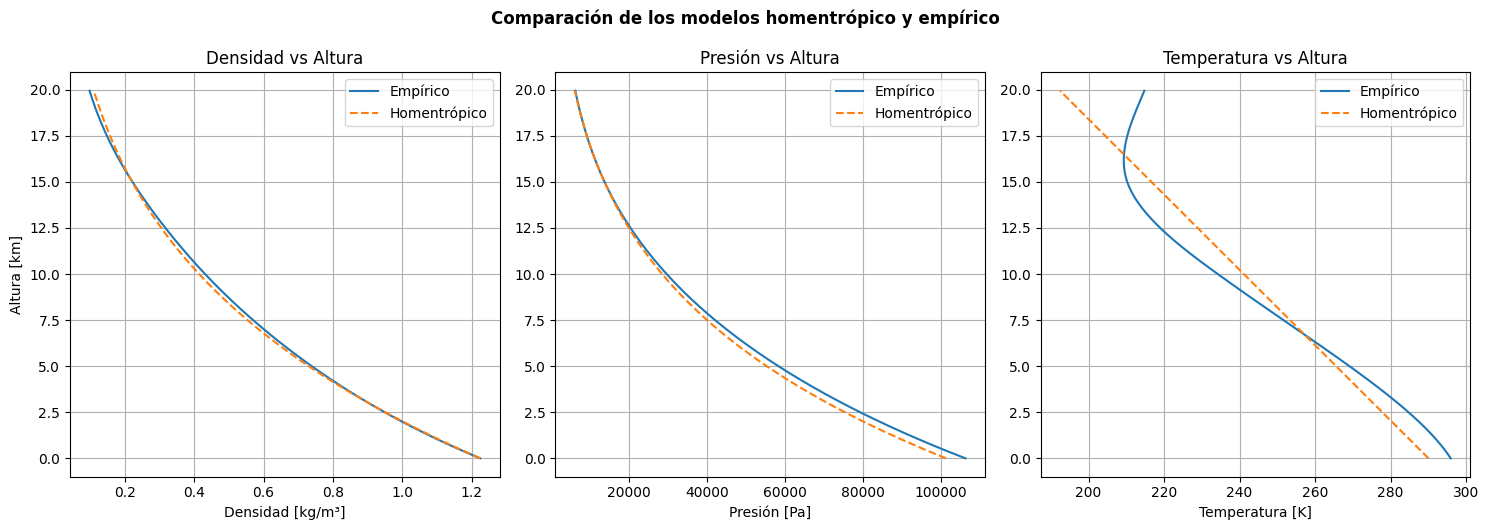

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots en una fila

# Densidad
axs[0].plot(rhos_emp, zs*m2km, label='Empírico', marker='', linestyle='-', markersize=4)
axs[0].plot(rhos_hom, zs*m2km, label='Homentrópico', marker='', linestyle='--')
axs[0].set_xlabel('Densidad [kg/m³]')
axs[0].set_ylabel('Altura [km]')
axs[0].set_title('Densidad vs Altura')
axs[0].legend()
axs[0].grid(True)

# Presión
axs[1].plot(ps_emp, zs*m2km, label='Empírico', marker='', linestyle='-', markersize=4)
axs[1].plot(ps_hom, zs*m2km, label='Homentrópico', marker='', linestyle='--')
axs[1].set_xlabel('Presión [Pa]')
axs[1].set_title('Presión vs Altura')
axs[1].legend()
axs[1].grid(True)

# Temperatura
axs[2].plot(Ts_emp, zs*m2km, label='Empírico', marker='', linestyle='-', markersize=4)
axs[2].plot(Ts_hom, zs*m2km, label='Homentrópico', marker='', linestyle='--')
axs[2].set_xlabel('Temperatura [K]')
axs[2].set_title('Temperatura vs Altura')
axs[2].legend()
axs[2].grid(True)

# Ajuste fino del layout
plt.tight_layout()
plt.suptitle('Comparación de los modelos homentrópico y empírico',
              y=1.05, fontweight='bold')
plt.show()


6. Repita el procedimiento anterior para muchos puntos en la superficie de la Tierra y haga mapas de $h_0$, $\gamma$ y $T_0$ sobre la superficie del planeta. Comente los resultados que obtiene.

Extrayendo la información empírica de los campos para diferentes latitudes

In [81]:
# Haciendo un mesgrid de latitudes y longitudes
lats = np.linspace(-90, 90, 20)
lons = np.linspace(-180, 180, 20)
LONS, LATS = np.meshgrid(lons,lats)

# Obteniendo los datos de la temperatura superficial para diferentes latitudes y longitudes
ds = msise_4d(date, zs*m2km, lats, lons)

# Reestructurandolo a un formato más simple
Ts_emp = np.array(ds["Talt"]).reshape(len(zs), len(lats), len(lons))
rhos_emp = np.array(ds["rho"]).reshape(len(zs), len(lats), len(lons))

# Lleva la densidad al sistema internacional
rhos_emp = rhos_emp*gr_cm3_2_kg_m3 # kg/m^3

# Usando la ecuación del gas ideal para obtener la presión empírica
ps_emp = rhos_emp * R * Ts_emp / Mmol # Pa

Ajustemos los parámetros para cada una de las latitudes y longitudes

In [82]:
# Ajustemos los parámetros para cada una de las latitudes y longitudes
optimized_params = np.zeros((len(lats), len(lons), 3))

for i in range(len(lats)):
    for j in range(len(lons)):
        # Ejecutar la minimización para la latitud y longitud actual
        result = minimize(chi_squared, initial_parameters, args=(zs, Ts_emp[:,i,j], rhos_emp[:,i,j], ps_emp[:,i,j]), bounds=bounds)

        # Manejo de errores
        if result.success:
            # Guarda los parámetros optimizados
            optimized_params[i,j] = result.x
        else:
            print(f"Optimization failed for lat={lats[i]}, lon={lons[j]}:", result.message)

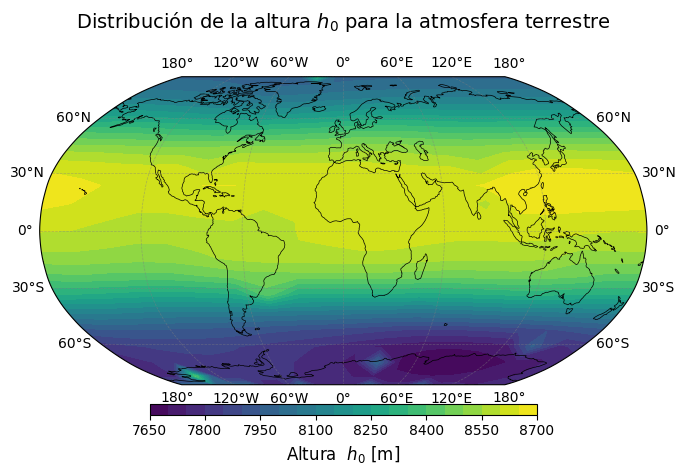

In [83]:
# Graficando el parámetro de h0 para diferentes latitudes y longitudes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
# Líneas costeras más finas
ax.coastlines(resolution='110m', linewidth=0.5)  
# Cuadrícula con etiquetas
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Mejora de la visualización de la tropopausa usando una mejor paleta de colores
tropopause_contour = ax.contourf(LONS, LATS, optimized_params[:,:,0], 24, transform=ccrs.PlateCarree(), cmap='viridis')

# Barra de color
cbar = plt.colorbar(tropopause_contour, orientation='horizontal', pad=0.05, aspect=36, shrink=0.5)
cbar.set_label(r'Altura  $h_0$ [m]', fontsize=12)  # Etiqueta de la barra de color   
cbar.ax.tick_params(labelsize=10)  # Tamaño de la fuente para los ticks de la barra de color

# Título y mejoras en las etiquetas
plt.title(r'Distribución de la altura $h_0$ para la atmosfera terrestre', fontsize=14, pad=20)

plt.show()

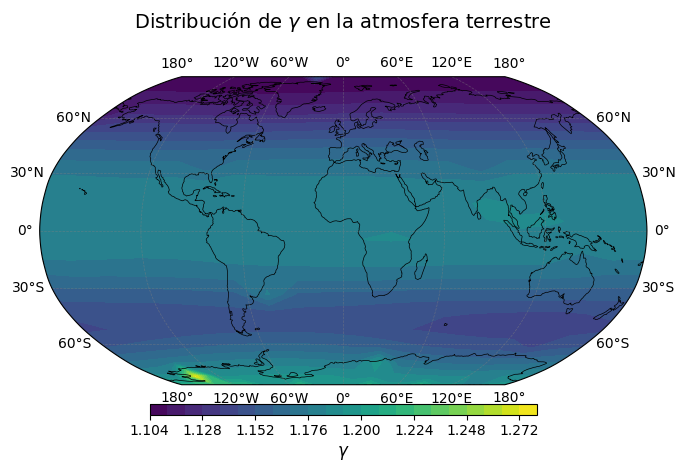

In [84]:
# Graficando el parámetro gamma para diferentes latitudes y longitudes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)  # Líneas costeras más finas
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Mejora de la visualización de la tropopausa usando una mejor paleta de colores
tropopause_contour = ax.contourf(LONS, LATS, optimized_params[:,:,1], 24, transform=ccrs.PlateCarree(), cmap='viridis')
# Barra de color con ajustes para ser más informativa
cbar = plt.colorbar(tropopause_contour, orientation='horizontal', pad=0.05, aspect=36, shrink=0.5)
cbar.set_label(r'$\gamma$', fontsize=12)  # Etiqueta de la barra de color
cbar.ax.tick_params(labelsize=10)  # Tamaño de la fuente para los ticks de la barra de color

# Título y mejoras en las etiquetas
plt.title(r'Distribución de $\gamma$ en la atmosfera terrestre', fontsize=14, pad=20)

plt.show()

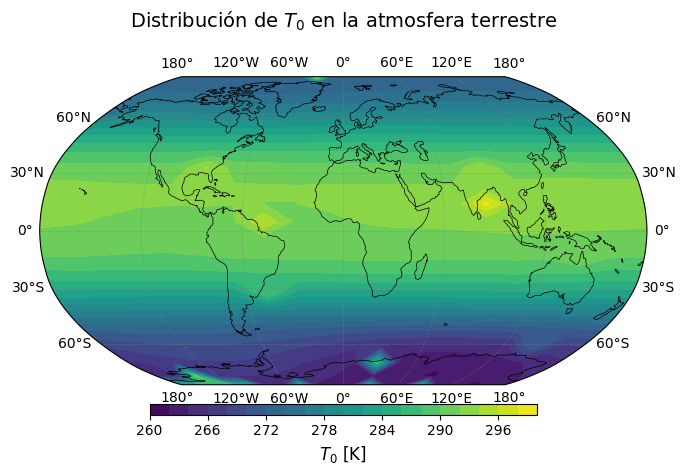

In [85]:
# Graficando el parámetro de temperatura inicial para diferentes latitudes y longitudes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)  # Líneas costeras más finas
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Mejora de la visualización de la tropopausa usando una mejor paleta de colores
tropopause_contour = ax.contourf(LONS, LATS, optimized_params[:,:,2], 24, transform=ccrs.PlateCarree(), cmap='viridis')
# Barra de color con ajustes para ser más informativa
cbar = plt.colorbar(tropopause_contour, orientation='horizontal', pad=0.05, aspect=36, shrink=0.5)
cbar.set_label(r'$T_0$ [K]', fontsize=12)  # Etiqueta de la barra de color
cbar.ax.tick_params(labelsize=10)  # Tamaño de la fuente para los ticks de la barra de color

# Título y mejoras en las etiquetas
plt.title(r'Distribución de $T_0$ en la atmosfera terrestre', fontsize=14, pad=20)

plt.show()

En todos los gráficos en representación de la atmosfera terrestre alrededor del planeta realizados durante el desarrollo de este trabajo se observa que las mayores diferencias entre las caracteristicas de la atmosfera estan asociadas a los cambios en la latitud terrestre y no tanto a la longitud.

A diferencia de lo que uno esperaría como una simetria en las características atmosferícas entre las regiones cerca al norte  y las del sur por la simetría esferíca del planeta esto no se presenta de hecho estás regiones son las que representan una mayor diferencia entre si mismas, esto debe de ser debido a la inclinación del planeta que genera que la cantidad de energía solar recibida en un polo sea muy difrente al otro a lo largo del tiempo.

---
### Referencias

Para el desarrollo de algunas partes de este notebook, se utilizó ChatGPT, un modelo de lenguaje de OpenAI, como herramienta de asistencia. Las interacciones con ChatGPT ayudaron en la conceptualización, codificación y depuración de las secciones relevantes.